<a href="https://colab.research.google.com/github/zahra370/D_PROJ2/blob/main/Final_part2_zahra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.5 MB/s eta 0:00:00


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/sem_seg/train'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/sem_seg/train/images/f_r_174_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1616_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_154_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1672_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1840_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1684_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1621_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1854_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1783_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1545_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1565_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1656_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1765_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1701_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1556_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1538_.jpg
/content/drive/MyDrive/sem_seg/train/images/f_r_1736_.jpg
/content/drive/M

In [ ]:
import matplotlib.pyplot as plt
import os
import imageio
import random
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint
import segmentation_models as sm

Segmentation Models: using `keras` framework.


1525


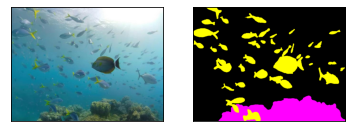

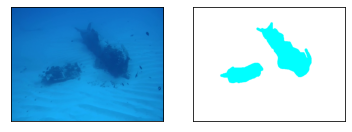

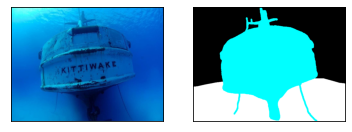

In [ ]:
dirname = r"/content/drive/MyDrive/sem_seg/train"
filenames = os.listdir(os.path.join(dirname,'images'))
filenames = [x for x in filenames if x.endswith('jpg')]
print(len(filenames))
nums = random.sample(range(len(filenames)),3)
for num in nums:
    filename = filenames[num]
    img = imageio.imread(os.path.join(dirname,'images', filename))
    lab = imageio.imread(os.path.join(dirname,'masks', filename[:-3] + 'bmp'))
    plt.figure()
    ax = plt.subplot(121)
    plt.imshow(img)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax = plt.subplot(122)
    plt.imshow(lab)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [ ]:
dict = {'classes': ['Background', 'Human divers', 'Aquatic plants and sea-grass', 'Wrecks and ruins', 'Robots', 'Reefs and invertebrates', 'Fish and vertebrates', 'Sea-floor and rocks'], 
        'colors': [(0,0,0), (0,0,255), (0,255,0), (0,255,255), (255,0,0), (255,0,255), (255,255,0), (255,255,255)]}

img_dim = (256,256,3)
perc_train = 0.8
batch_size=32
n_classes=8

In [ ]:
paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/sem_seg/train'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

im_files = [x for x in paths if x.endswith('jpg')]
lab_files = [x for x in paths if x.endswith('bmp')]
im_files.sort()
lab_files.sort()

In [ ]:
print(len(im_files))
print(len(lab_files))

1525
1525


In [ ]:
def labelize(label):
    m,n,b = label.shape
    ref = np.zeros((m,n))
    for i,col in enumerate(dict['colors']):
        ref[np.all(label == col,axis=-1)] = i
    return ref

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, list_labels, batch_size=32, img_dim = (256,256), n_channels = 3, n_classes=10, shuffle=True):
        'Initialization'
        self.dim = img_dim
        self.batch_size = batch_size
        self.labels = list_labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        list_lab_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp, list_lab_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp, list_labels):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = img_to_array(load_img(ID,target_size = ( *self.dim, self.n_channels), interpolation = 'bicubic'))/255

            # Store class
            yy = img_to_array(load_img(list_labels[i], target_size = ( *self.dim, self.n_channels), interpolation= 'nearest'))
            y[i,] = labelize(yy)
        return X, to_categorical(y, num_classes=self.n_classes)

In [ ]:
def unet_model(n_classes=n_classes, img_dim = img_dim):
#Build the model
    inputs = Input(img_dim)
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
metrics=['accuracy', jaccard_coef]
loss = sm.losses.DiceLoss() 
model1= unet_model()
model1.summary()
model1.compile(optimizer='adam', loss=loss, metrics=metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model1.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [ ]:
L = len(im_files)
indices = np.arange(L)
L1 = int(L*perc_train)
t_gen = DataGenerator(im_files[:L1], lab_files[:L1], batch_size=batch_size, img_dim = (256,256), n_channels = 3, n_classes=8, shuffle=True)
v_gen = DataGenerator(im_files[L1:], lab_files[L1:], batch_size=batch_size, img_dim = (256,256), n_channels = 3, n_classes=8, shuffle=True)

In [ ]:
history = model1.fit(t_gen, 
                    verbose=1, 
                    epochs=35, 
                    validation_data=v_gen)

Epoch 1/35
38/38 [==============================] - 435s 11s/step - loss: 0.8518 - accuracy: 0.4954 - jaccard_coef: 0.2811 - val_loss: 0.8651 - val_accuracy: 0.3588 - val_jaccard_coef: 0.2193
Epoch 2/35
38/38 [==============================] - 57s 2s/step - loss: 0.8077 - accuracy: 0.5681 - jaccard_coef: 0.3521 - val_loss: 0.8364 - val_accuracy: 0.3962 - val_jaccard_coef: 0.2301
Epoch 3/35
38/38 [==============================] - 50s 1s/step - loss: 0.7811 - accuracy: 0.5585 - jaccard_coef: 0.3714 - val_loss: 0.8211 - val_accuracy: 0.4125 - val_jaccard_coef: 0.2540
Epoch 4/35
38/38 [==============================] - 51s 1s/step - loss: 0.7771 - accuracy: 0.5532 - jaccard_coef: 0.3764 - val_loss: 0.8209 - val_accuracy: 0.4109 - val_jaccard_coef: 0.2525
Epoch 5/35
38/38 [==============================] - 50s 1s/step - loss: 0.7668 - accuracy: 0.5713 - jaccard_coef: 0.3904 - val_loss: 0.8079 - val_accuracy: 0.4090 - val_jaccard_coef: 0.2512
Epoch 6/35
38/38 [==============================

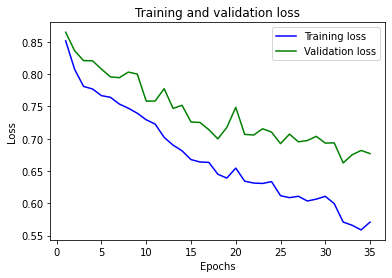

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

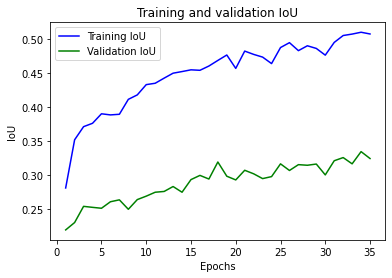

In [ ]:
acc = history.history['jaccard_coef']
val_acc = history.history['val_jaccard_coef']

plt.plot(epochs, acc, 'b', label='Training IoU')
plt.plot(epochs, val_acc, 'g', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


def DeeplabV3Plus():
    num_classes = 8
    model_input = keras.Input(shape=(256, 256, 3))
    image_size = 256
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)




In [ ]:
metrics2=['accuracy', jaccard_coef]
loss2 = sm.losses.DiceLoss() 
model2= DeeplabV3Plus()
model2.summary()
model2.compile(optimizer='adam', loss=loss2, metrics=metrics2)

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
EarlyStop2=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR2=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check2=ModelCheckpoint('model2.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback2=[EarlyStop2 , Reduce_LR2,model_check2]
 

In [ ]:
L2 = len(im_files)
indices2 = np.arange(L2)
L11 = int(L2*perc_train)
t_gen2 = DataGenerator(im_files[:L11], lab_files[:L11], batch_size=batch_size, img_dim = (256,256), n_channels = 3, n_classes=8, shuffle=True)
v_gen2 = DataGenerator(im_files[L11:], lab_files[L11:], batch_size=batch_size, img_dim = (256,256), n_channels = 3, n_classes=8, shuffle=True)

In [ ]:
history2 = model2.fit(t_gen2, 
                    verbose=1, 
                    epochs= 3, 
                    validation_data=v_gen2)

Epoch 1/3
38/38 [==============================] - 2717s 71s/step - loss: 0.8094 - accuracy: 0.2350 - jaccard_coef: 0.1221 - val_loss: 0.7433 - val_accuracy: 0.1705 - val_jaccard_coef: 0.1477
Epoch 2/3
38/38 [==============================] - 2776s 73s/step - loss: 0.7250 - accuracy: 0.2073 - jaccard_coef: 0.1598 - val_loss: 0.7392 - val_accuracy: 0.0023 - val_jaccard_coef: 0.0086
Epoch 3/3
38/38 [==============================] - 2707s 71s/step - loss: 0.7729 - accuracy: 0.1961 - jaccard_coef: 0.3134 - val_loss: 0.7488 - val_accuracy: 0.0747 - val_jaccard_coef: -1.0932


In [ ]:
model1.save('saved_models/unet.hdf5')

In [ ]:
model2.save('saved_models/deeplabv3+.hdf5')

In [ ]:
paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/sem_seg/test'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))

t_in_files = [x for x in paths if x.endswith('jpg')]
t_lab_files = [x for x in paths if x.endswith('bmp')]
t_in_files.sort()
t_lab_files.sort()

In [ ]:
test_set = []
test_lab = []
for i in range(len(t_in_files)):
    test_set.append(img_to_array(load_img(t_in_files[i],target_size = img_dim, interpolation = 'bicubic'))/255)
    yy = img_to_array(load_img(t_lab_files[i], target_size = img_dim, interpolation= 'nearest'))
    test_lab.append(to_categorical(labelize(yy),num_classes=8))
test_set = np.asarray(test_set)
test_lab = np.asarray(test_lab)

In [ ]:
y_pred=model1.predict(test_set)
Jacc = jaccard_coef(test_lab,y_pred)
print('IoU = {}'.format(Jacc))
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(test_lab, axis=3)

4/4 [==============================] - 2s 421ms/step
IoU = 0.2719534635543823


1/1 [==============================] - 1s 555ms/step


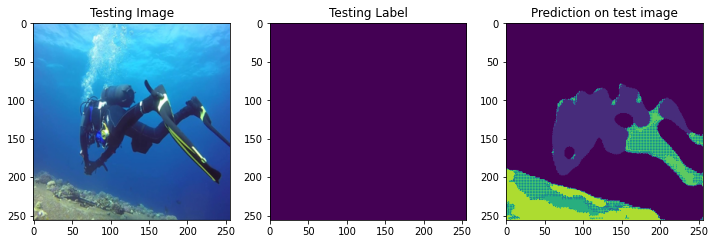

1/1 [==============================] - 0s 18ms/step


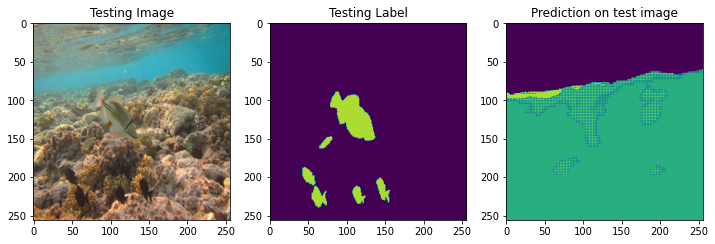

1/1 [==============================] - 0s 25ms/step


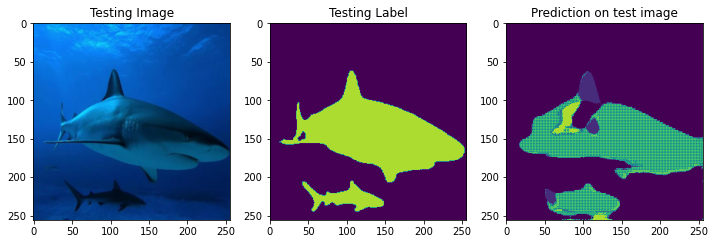

In [ ]:
num_samples = 3
test_img_numbers = random.sample(range(test_set.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = test_set[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model1.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()

In [ ]:
# from tensorflow import keras
# from sklearn.metrics import accuracy_score

# model1 = keras.models.load_model('unet.hdf5')

# model2 = keras.models.load_model('saved_models/deeplabv3+.hdf5')

1/1 [==============================] - 0s 22ms/step


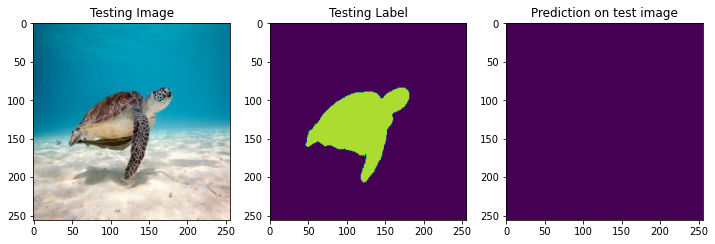

1/1 [==============================] - 0s 27ms/step


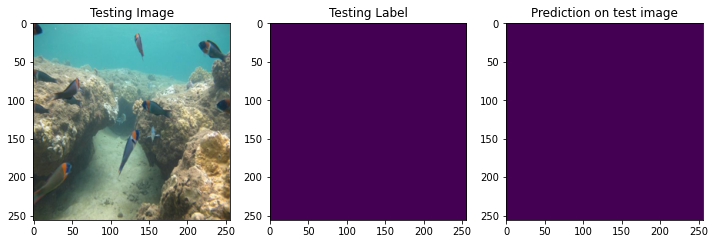

1/1 [==============================] - 0s 24ms/step


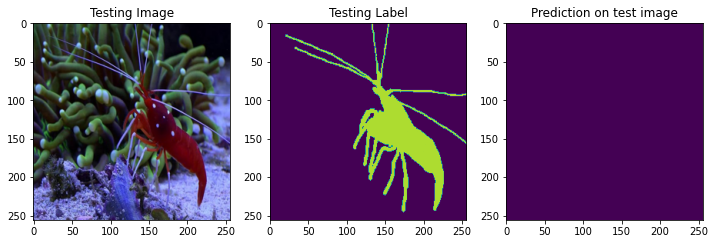

In [ ]:
num_samples = 3
test_img_numbers = random.sample(range(test_set.shape[0]), num_samples)
for test_img_number in test_img_numbers:
    test_img = test_set[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model2.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth, vmin=0, vmax = n_classes)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, vmin=0, vmax = n_classes)
    plt.show()